## Explore an image

In [1]:
if True:
  # Clone repository with example images
  # This is an example from last years. Do not put your dataset into your own repository!
  !rm -rf fyp2022-imaging
  !git clone https://github.com/vcheplygina/fyp2022-imaging.git

'rm' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'fyp2022-imaging' already exists and is not an empty directory.


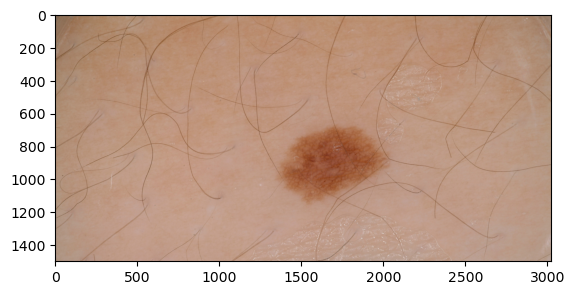

In [24]:
# Prepare an image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

file_im = 'fyp2022-imaging/data/example_image/ISIC_0001769.jpg'
im = plt.imread(file_im)

im2 = im[0:1500,:,:] 
plt.imshow(im2, cmap='gray')

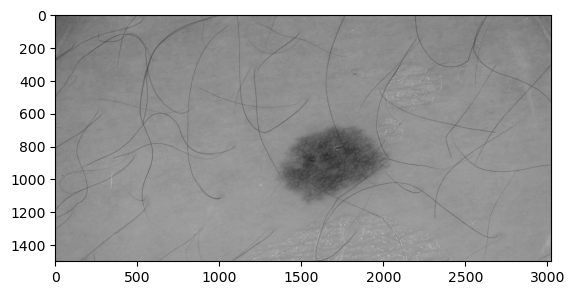

In [13]:
#Crop the image to remove the marker, convert it to RGB and display
#ADD CODE HERE

im3 = im[0:1500,:,:]
im3 = rgb2gray(im2)*256
plt.imshow(im3, cmap='gray')

(2016, 3024, 3)
uint8
0
255
[[[157 118  87]]]


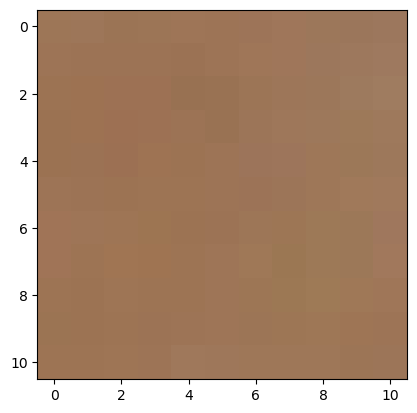

In [14]:
# Simple steps to explore what is in the image

print(im.shape)
print(im.dtype)
print(np.min(im))
print(np.max(im))

# Show only one pixel
pixel = im[100:101,100:101,:]
print(pixel)
plt.imshow(pixel)

# Now display a 10x10 area of the image
# INSERT CODE HERE
pixels = im[100:111,100:111,:]
plt.imshow(pixels)


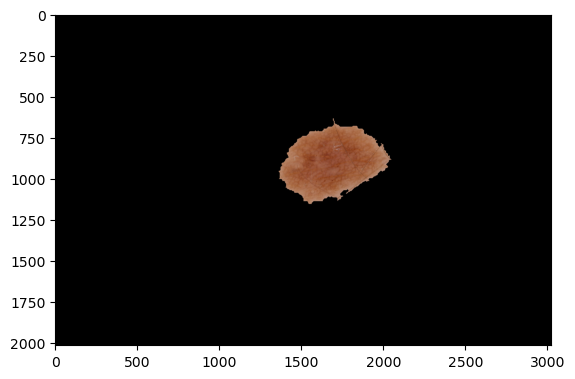

In [5]:
# Load a "ground truth" segmentation mask for the original image (for this dataset, this is already available)
gt=plt.imread('fyp2022-imaging/data/example_segmentation/ISIC_0001769_segmentation.png')
plt.imshow(gt, cmap="gray")

# We can use the mask to only see the lesion
im2 = im.copy()
im2[gt==0] = 0

# Display
plt.imshow(im2)


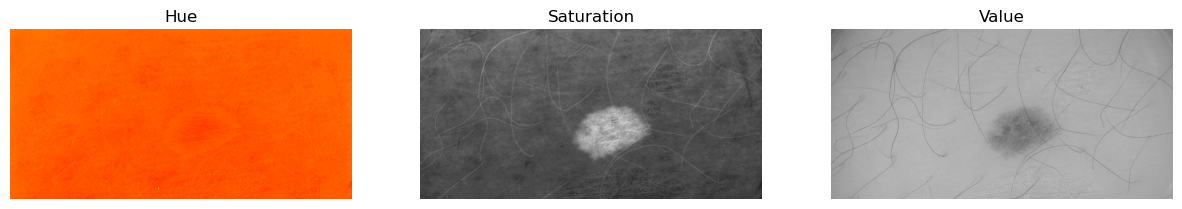

In [15]:
# Try the HSV color representation
from skimage.color import rgb2hsv

hsv_im = rgb2hsv(im2)

# Inspect the channels one by one / display them side by side.
plt.figure(figsize=(15, 5))

# Display Hue channel
plt.subplot(1, 3, 1)
plt.imshow(hsv_im[:, :, 0], cmap='hsv')
plt.title('Hue')
plt.axis('off')

# Display Saturation channel
plt.subplot(1, 3, 2)
plt.imshow(hsv_im[:, :, 1], cmap='gray')
plt.title('Saturation')
plt.axis('off')

# Display Value channel
plt.subplot(1, 3, 3)
plt.imshow(hsv_im[:, :, 2], cmap='gray')
plt.title('Value')
plt.axis('off')

plt.show()

**QUESTION:** Looking at these channels one by one, what do you notice that could help with preprocessing the image?

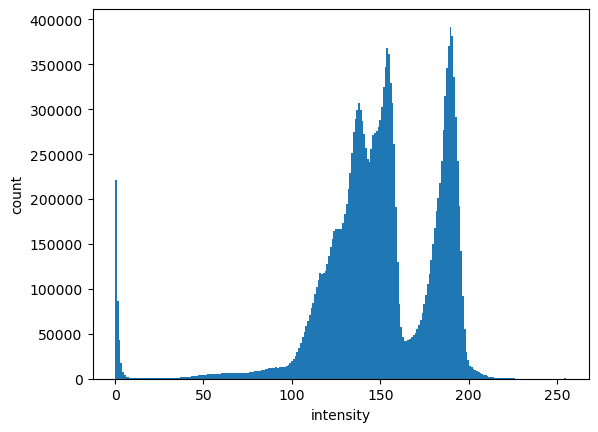

In [7]:
# Look at the histogram

im_hist = plt.hist(im.flatten(), bins = 256)

# Add intensity and count labels to the plot, and show it
plt.xlabel('intensity')
plt.ylabel('count')
plt.show()

**QUESTION**:

Why do we need to do the flatten() operation above, instead of just im_hist = plt.hist(im2, bins = 256) ?



## Morphology

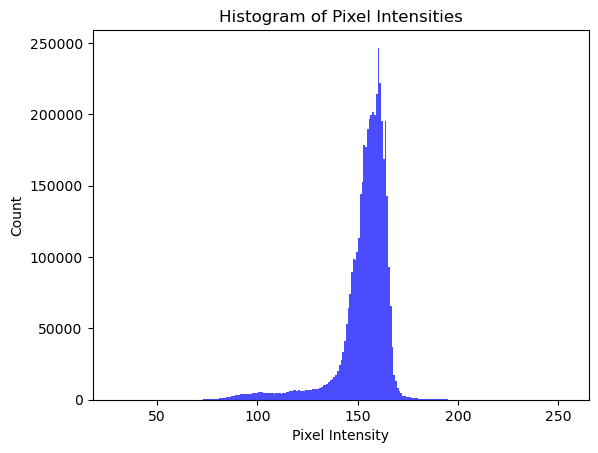

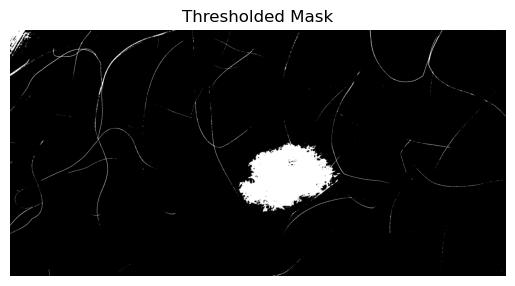

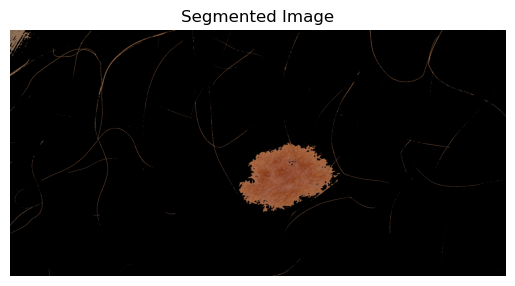

In [18]:
# Create a mask by thresholding the image, based on the histogram
# Convert the image to grayscale if it isn't already
im_gray = rgb2gray(im2) * 255  # Scale to 0-255 range

# Plot the histogram to help determine the threshold
plt.hist(im_gray.flatten(), bins=256, color='blue', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')
plt.title('Histogram of Pixel Intensities')
plt.show()

# Choose a threshold value based on the histogram
# For example, if the lesion is darker than the background, choose a lower threshold
threshold = 120  # Adjust this value based on the histogram

# Create the mask
mask = im_gray < threshold  # Pixels below the threshold are part of the lesion

# Display the mask
plt.imshow(mask, cmap='gray')
plt.title('Thresholded Mask')
plt.axis('off')
plt.show()

# Apply the mask to the original image to visualize the segmentation
segmented_im = im2.copy()
segmented_im[~mask] = 0  # Set pixels outside the mask to black

# Display the segmented image
plt.imshow(segmented_im)
plt.title('Segmented Image')
plt.axis('off')
plt.show()

[[0 1 0]
 [1 1 1]
 [0 1 0]]


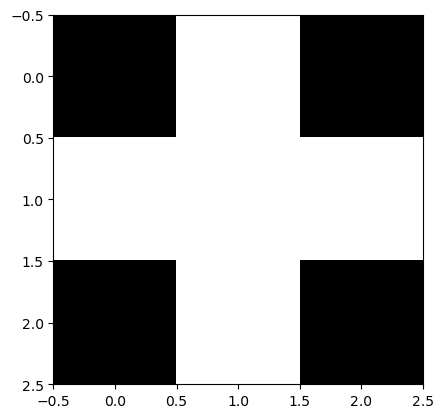

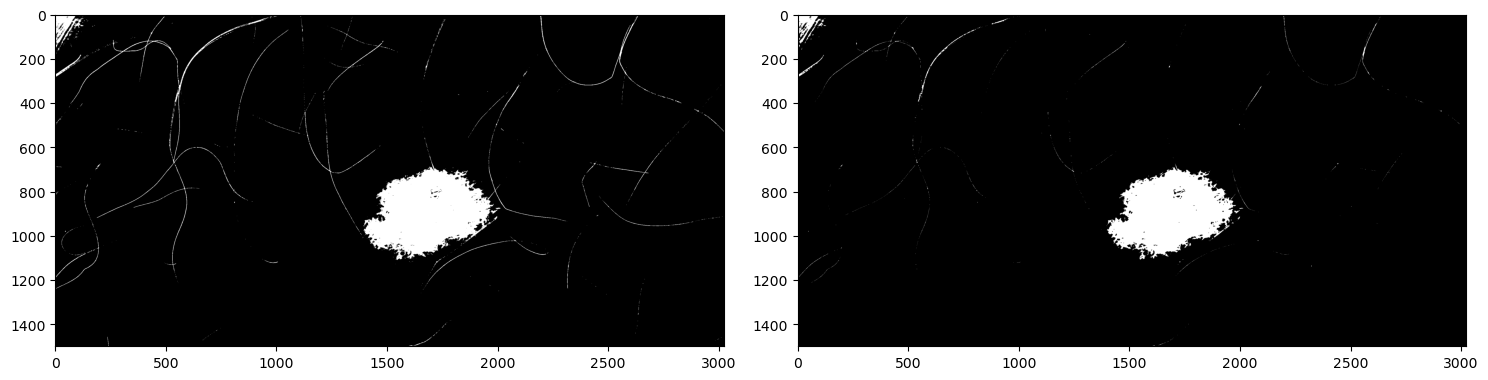

In [19]:
# Postprocessing with morphology

from skimage import morphology

# Structural element, that we will use as a "brush". The parameter is "brush size"
struct_el = morphology.disk(1)

print(struct_el)
plt.imshow(struct_el, cmap='gray')

# Use this "brush" to erode the image
mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show the original mask and the result side by side

# INSERT CODE HERE
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()


**QUESTION**: Experiment with different parameters of the structural element, what kind of size seems to lead to better results

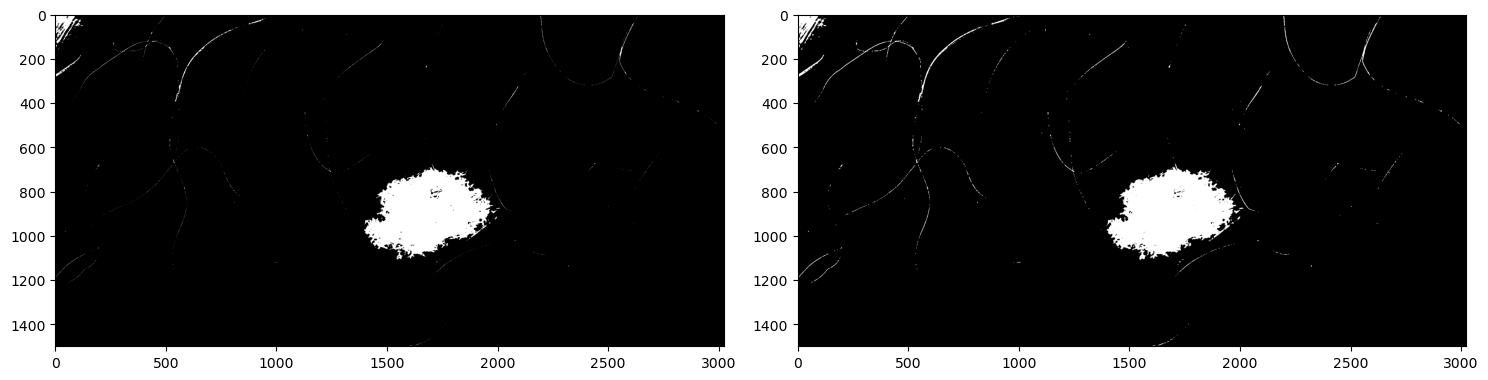

In [20]:
# After erosion, there are probably some holes in the lesion. Close them by using morphology.binary_dilation and inspect the images side by side

# INSERT CODE HERE
mask_dilated = morphology.binary_dilation(mask_eroded, struct_el)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(mask_eroded, cmap='gray')
axes[1].imshow(mask_dilated, cmap='gray')
fig.tight_layout()

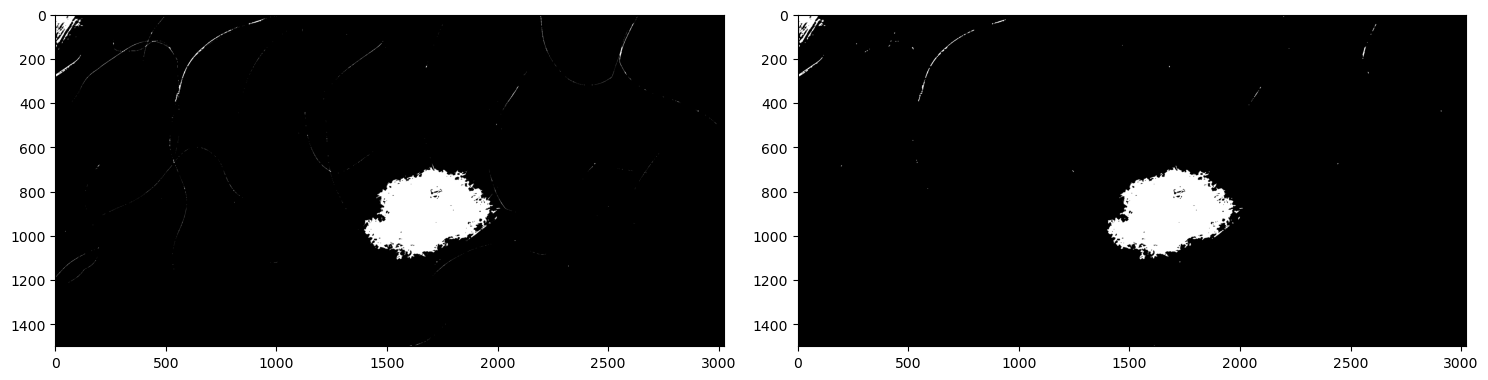

In [21]:
# You can try to achieve the same result in one step: morphology.binary_opening

# After erosion, there are probably some holes in the lesion. 
# Use morphology.binary_opening to close them and inspect the images side by side.

# Perform binary opening to achieve the same result in one step
mask_opened = morphology.binary_opening(mask_eroded, struct_el)

# Display the original eroded mask and the opened mask side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(mask_eroded, cmap='gray')
axes[1].imshow(mask_opened, cmap='gray')
fig.tight_layout()

Dice Score (Improved Combined Mask): 0.053386722329470136


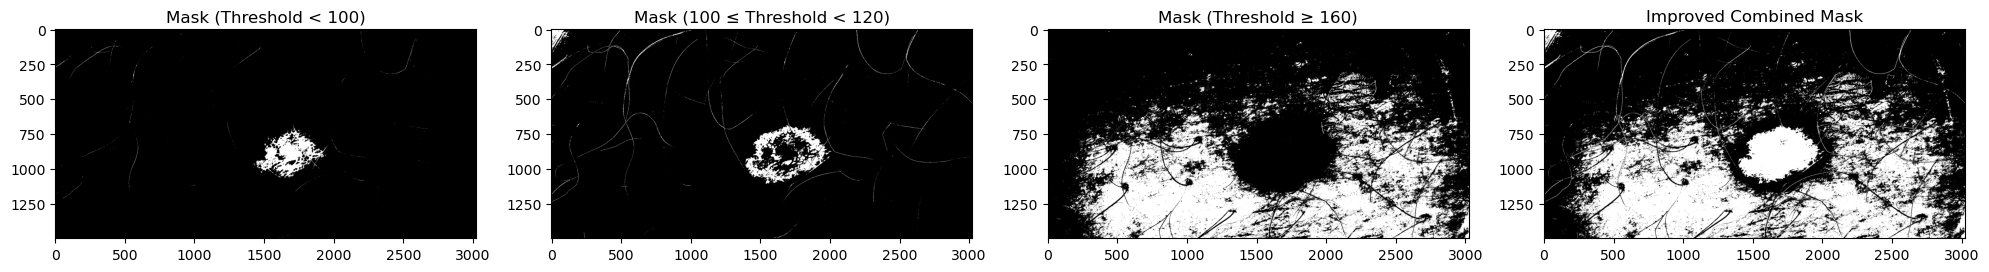

In [45]:
# Define additional thresholds for experimentation
threshold_mid = 120  
threshold_high = 160  

# Create multiple masks using different thresholds
mask_low = (im_gray < threshold_low).astype(np.uint8)
mask_mid = ((im_gray >= threshold_low) & (im_gray < threshold_mid)).astype(np.uint8)
mask_high = (im_gray >= threshold_high).astype(np.uint8)

# Combine masks using logical OR to include more meaningful regions
combined_mask = np.logical_or(mask_low, np.logical_or(mask_mid, mask_high)).astype(np.uint8)

# Calculate the Dice score for the combined mask
intersection_combined = np.sum(combined_mask * gt_resized)
dice_combined = (2 * intersection_combined) / (np.sum(combined_mask) + np.sum(gt_resized))

print(f"Dice Score (Improved Combined Mask): {dice_combined}")

# Visualize the masks
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
axes[0].imshow(mask_low, cmap='gray')
axes[0].set_title(f"Mask (Threshold < {threshold_low})")
axes[1].imshow(mask_mid, cmap='gray')
axes[1].set_title(f"Mask ({threshold_low} ≤ Threshold < {threshold_mid})")
axes[2].imshow(mask_high, cmap='gray')
axes[2].set_title(f"Mask (Threshold ≥ {threshold_high})")
axes[3].imshow(combined_mask, cmap='gray')
axes[3].set_title("Improved Combined Mask")
fig.tight_layout()


**NOTE**: since you will be using Dice multiple times it's best to put it in a function so you do not duplicate code

## Area and perimeter

In [ ]:
# Preparing some example images

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Function to get us some example images and their masks, and resize them (just for efficiency)
def prepare_im(im_id):

  path = 'fyp2022-imaging/data/'

  im = plt.imread(path + 'example_image/' + im_id + '.jpg')
  im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)

  gt = plt.imread(path + 'example_segmentation/' + im_id + '_segmentation.png')
  gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=False)

  gt = gt>0  #This is because resizing creates some non-zero values

  return im, gt


# Get some examples

im1, mask1 = prepare_im('ISIC_0001871')
im2, mask2 = prepare_im('ISIC_0012151')

plt.imshow(mask1, cmap='gray')

In [ ]:
# Calculate the area using the image mask
# INSERT CODE HERE

area = np.sum(mask1)

In [ ]:
# Measure diameter of the lesion: measure height or width of the mask

#How many 1's in each column of the image (sum over axis 0, i.e. rows)
pixels_in_col = np.sum(mask1, axis=0)
max_pixels_in_col = np.max(pixels_in_col)
print('height is', max_pixels_in_col)

# Do the same for the rows of the image
# INSERT CODE HERE
# pixels_in_row =

In [ ]:
# What if we want to measure diameter at an angle?

# General rule of thumb - create a simpler image first, then do the measurement

from skimage import transform
rot_im = transform.rotate(mask1, 45)
plt.imshow(rot_im, cmap='gray')

In [ ]:
# Find the perimeter - again, do not go through the pixels but make a simpler image first and then use the masks


from skimage import morphology

#Structural element, that we will use as a "brush" on our mask
struct_el = morphology.disk(1)

#plt.imshow(struct_el)

# Use this "brush" to erode the image - eat away at the borders
mask_eroded = morphology.binary_erosion(mask1, struct_el)

# Show side by side (depending on brush size, you might not see a difference visually)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask1, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()


# Verify the new mask is smaller
print(area)
print(np.sum(mask_eroded))


In [ ]:
# Now we can find the pixels that have value 1 in the original mask but not in the eroded mask

perimeter_im = mask1 - mask_eroded

plt.imshow(perimeter_im, cmap='gray')

# The perimeter now is just the sum of the mask
print(np.sum(perimeter_im))


In [ ]:
# EXERCISE: Generate a binary image with a circle in it
# From https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


circle = create_circular_mask(100,100)
plt.imshow(circle, cmap='gray')

#INSERT CODE HERE

# Add some padding to the image (black rows and columns)

# Now calculate the area and perimeter and find their ratio (compactness or similar)

# Try varying the size of the circular mask and calculate these values again, what do you observe? ß